## Exploring the Effect of Lunar Illumination in DDFs

**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 04/13/2021
<br>**Short description:** See [Here](https://community.lsst.org/t/lunar-complications-in-the-scheduling-of-deep-drilling-fields-rtn-014/4720) for a much more indepth discussion. This notebook will specifically demonstrate the associated negative impacts as observed in 'agnddf_v1.5' and 'descddf_v1.5'

### 0. Software Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

In [2]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [3]:
# add the path the scripts
sys.path.insert(0, '../src/')

In [5]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

# # import custom stacker/metrics from script
# from AGNStacker import MagErrStacker
# from AGNMetrics import SFErrorMetric

In [7]:
ddfFields = ['COSMOS', 'XMM-LSS', 'ELAISS1', 'ECDFS', 'EDFS']

In [7]:
from lsst.sims.maf.metrics import TgapsMetric, Coaddm5Metric, CountMetric

### 1. Run MAF
- Set up connection
- Define metrics to run
- Run

#### 1.1 Connect to Dbs

In [6]:
# connect to database
descddf_opsdb = db.OpsimDatabase(f'/home/idies/workspace/lsst_cadence/FBS_1.5/descddf_v1.5_10yrs.db')
agnddf_opsdb = db.OpsimDatabase(f'/home/idies/workspace/lsst_cadence/FBS_1.5/agnddf_v1.5_10yrs.db')
baseline_opsdb = db.OpsimDatabase(f'/home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db')
outDir = '/home/idies/workspace/Temporary/{}/scratch/MAFOutput/tmp/SF/DDF/041321/'.format(your_username)
resultsDb = db.ResultsDb(outDir=outDir)

#### 1.2 Define metrics, slicers and sql constraints

In [10]:
from lsst.sims.utils import hpid2RaDec, angularSeparation
import healpy as hp

In [11]:
# define slicer
nside = 64
ddf_radius = 1.8
mag = 24
ddf_idx = 3
ddf_ra = ddfCoord[ddfFields[ddf_idx]][0]
ddf_dec = ddfCoord[ddfFields[ddf_idx]][1]

# determine pixels around DDF
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
dist2ddf = angularSeparation(ra, dec, ddf_ra, ddf_dec)
good_pixel = np.where(dist2ddf <= ddf_radius)

# define special slicer
ddf_slicer = slicers.UserPointsSlicer(ra=ra[good_pixel], dec=dec[good_pixel], 
                                      useCamera=False, latLonDeg=True)

In [12]:
# define separate metric and sql constraint
pass_metric = metrics.PassMetric(cols=['fiveSigmaDepth', 'fieldDec', 'fieldRA', 
                                        'airmass', 'skyBrightness', 'seeingFwhmEff',
                                        'moonDistance', 'filter'])

# sql
ddf_sql = 'visitExposureTime > 11'
wfd_sql = ddf_sql + ' and note not like "DD%"'

# metric bundle and bundle group for desc_ddf
desc_mb = metricBundles.MetricBundle(pass_metric, ddf_slicer, ddf_sql)
desc_mbg = metricBundles.MetricBundleGroup({'Pass_COSMOS': desc_mb}, descddf_opsdb, 
                                            outDir, resultsDb, verbose=False)

# metric bundle and bundle group for agn_ddf
agn_mb = metricBundles.MetricBundle(pass_metric, ddf_slicer, ddf_sql)
agn_mbg = metricBundles.MetricBundleGroup({'Pass_COSMOS': agn_mb}, agnddf_opsdb, 
                                            outDir, resultsDb, verbose=False)

# metric bundle and bundle group for baseline
base_mb = metricBundles.MetricBundle(pass_metric, ddf_slicer, ddf_sql)
base_mbg = metricBundles.MetricBundleGroup({'Pass_COSMOS': base_mb}, baseline_opsdb, 
                                            outDir, resultsDb, verbose=False)

In [13]:
# run both
desc_mbg.runAll()
agn_mbg.runAll()
base_mbg.runAll()

#### 1.3 Plot distributions

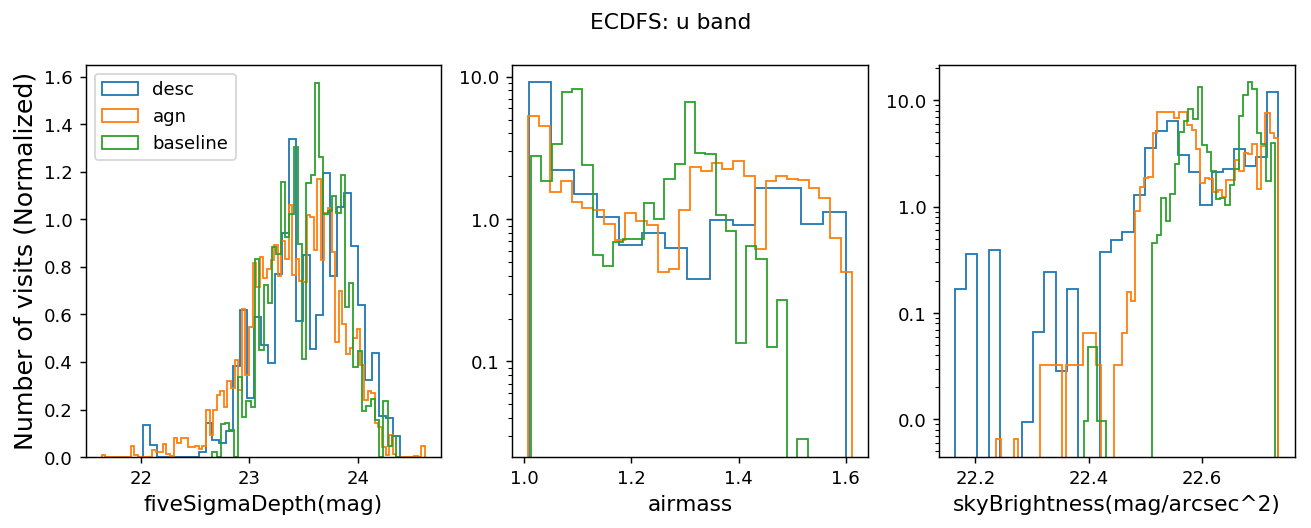

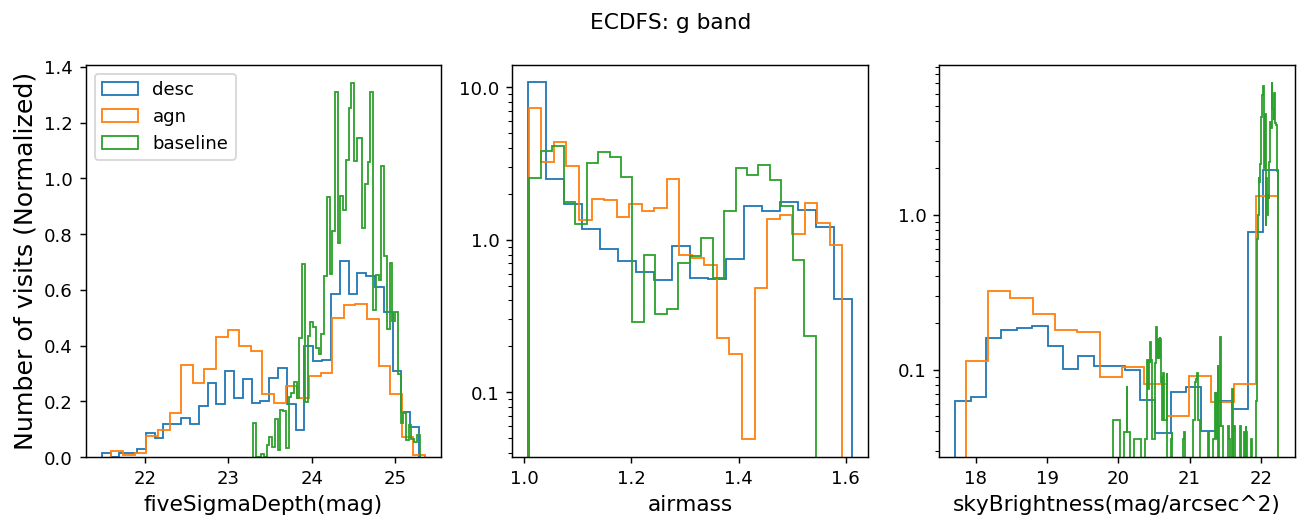

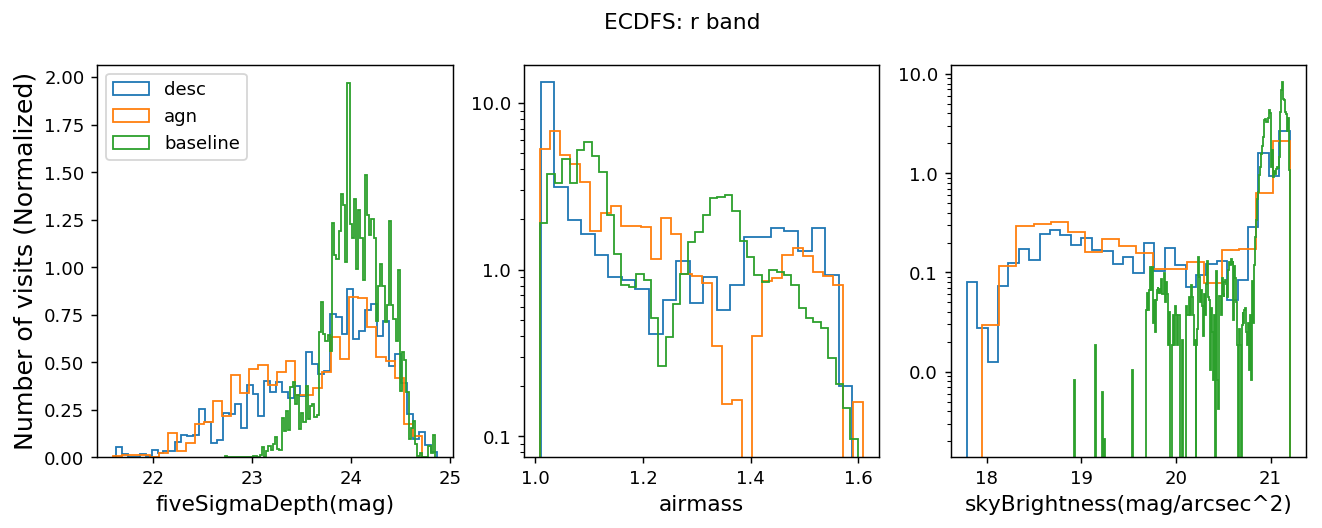

In [19]:
for filt in ['u', 'g', 'r']:
    
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, dpi=130, figsize=(12, 4), sharex=False)

    col1 = 'fiveSigmaDepth'
    col2 = 'airmass'
    col3 = 'skyBrightness'

    # desc_ddf
    desc_data = np.concatenate(desc_mb.metricValues.data)
    desc_data = desc_data[desc_data['filter'] == f'{filt}']
    _ = ax1.hist(desc_data[f'{col1}'], histtype='step', bins='fd', density=True, label=f'desc')
    _ = ax2.hist((desc_data[f'{col2}']), histtype='step', bins='fd', density=True, label=f'desc')
    _ = ax3.hist((desc_data[f'{col3}']), histtype='step', bins='fd', density=True, label=f'desc')

    # agn_ddf
    agn_data = np.concatenate(agn_mb.metricValues.data)
    agn_data = agn_data[agn_data['filter'] == f'{filt}']
    _ = ax1.hist(agn_data[f'{col1}'], histtype='step', bins='fd', density=True, label='agn')
    _ = ax2.hist(agn_data[f'{col2}'], histtype='step', bins='fd', density=True, label='agn')
    _ = ax3.hist(agn_data[f'{col3}'], histtype='step', bins='fd', density=True, label=f'agn')
    #     _ = ax2.vlines(np.median(data['magErr']), ymin=0, ymax=350, linestyles='--', linewidth=1)

    # baseline
    base_data = np.concatenate(base_mb.metricValues.data)
    base_data = base_data[base_data['filter'] == f'{filt}']
    _ = ax1.hist(base_data[f'{col1}'], histtype='step', bins='fd', density=True, label='baseline')
    _ = ax2.hist(base_data[f'{col2}'], histtype='step', bins='fd', density=True, label='baseline')
    _ = ax3.hist(base_data[f'{col3}'], histtype='step', bins='fd', density=True, label=f'baseline')
    #     _ = ax2.vlines(np.median(data['magErr']), ymin=0, ymax=350, linestyles='--', linewidth=1)

    ## xlabel
    ax1.set_xlabel(col1+'(mag)', fontsize=12)
    ax2.set_xlabel(col2, fontsize=12)
    ax3.set_xlabel(col3+'(mag/arcsec^2)', fontsize=12)

    ## ylabel
    ax1.set_ylabel('Number of visits (Normalized)', fontsize=14)

    # adjust plots
    ax1.legend(loc=2)
    ax2.set_yscale('log', basey=10)
    ax3.set_yscale('log', basey=10)
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax3.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    fig.suptitle(f'{ddfFields[ddf_idx]}: {filt} band')
    
#     plt.savefig(f'ddf_{filt}.pdf')

__Note:__
As can be seen from the plot above, both 'agnddf_v1.5' and 'descddf_v1.5' spend a lot of the DDFs visits at high sky brightness (close to the moon), which result in a reduce coadd depth (less usable visits for variablity science at the faint end). u band is not affect since u filter is not loaded into the wheel until lunar illumination < 40%.

## --------------- Stop ---------------------

In [ ]:
# ## u-band
# fig, [ax1, ax2] = plt.subplots(1, 2, dpi=130, figsize=(8, 4), sharex=False)

# # desc_ddf
# # for i, data in enumerate(desc_mb.metricValues.data):
# desc_data = np.concatenate(desc_mb.metricValues.data)
# _ = ax1.hist(desc_data['fiveSigmaDepth'], histtype='step', bins='fd', density=False, label=f'desc')
# _ = ax2.hist(desc_data['airmass'], histtype='step', bins='fd', density=True, label=f'desc')
# #     _ = ax1.vlines(np.median(data['magErr']), ymin=0, ymax=25, linestyles='--', linewidth=1.5)

# _ = ax1.plot([], [], label='Medians', linestyle='--', linewidth=1.5, c='k')

# # agn_ddf
# # for data in agn_mb.metricValues.data:
# agn_data = np.concatenate(agn_mb.metricValues.data)
# _ = ax1.hist(agn_data['fiveSigmaDepth'], histtype='step', bins='fd', density=False, label='agn')
# _ = ax2.hist(agn_data['airmass'], histtype='step', bins='fd', density=True, label='agn')
# #     _ = ax2.vlines(np.median(data['magErr']), ymin=0, ymax=350, linestyles='--', linewidth=1)

# # baseline
# # for data in base_mb.metricValues.data:
# base_data = np.concatenate(base_mb.metricValues.data)
# _ = ax1.hist(base_data['fiveSigmaDepth'], histtype='step', bins='fd', density=False, label='baseline')
# _ = ax2.hist(base_data['airmass'], histtype='step', bins='fd', density=True, label='baseline')
# #     _ = ax2.vlines(np.median(data['magErr']), ymin=0, ymax=350, linestyles='--', linewidth=1)

# # adjust plots
# ax1.legend()
# ax1.set_title('descddf_v1.5 (WFD only)')
# ax2.set_title('agnddf_v1.5 (extra DDF visits)')
# # ax1.set_xlabel('Photometric Error $\sigma$')
# # ax1.xaxis.set_major_locator(plt.FixedLocator(np.array([0.2, 0.4, 0.6, 0.8, 1.0])))
# # ax2.set_xlim(0, 1.)